In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Explore (train_set) AKA (train_loader.dataset)

In [5]:
print(train_set)             #trainset[IMAGEINDEX][0-image_tensor,1-class] [CHANNEL][HEIGHT][WIDTH]
print(train_set.data.shape)  #trainset.data[IMAGE INDEX][HEIGHT][WIDTH]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([60000, 28, 28])


In [15]:
# SINGLE
image , label = next(iter(train_set))   # SAME AS train_set[0] - train_set IS INDEXABLE
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In [16]:
# BATCH
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(train_loader)) #CANT USE train_loader[0] - NOT INDEXABLE
images , labels = batch          #LOADS 1 BATCH(10 images) AT ONCE
print(images.shape)

torch.Size([10, 1, 28, 28])


## Network & Training

In [21]:
class Network(nn.Module):
    
    def __init__(self, lr):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = F.cross_entropy
        
    def forward(self, t):
        #conv layer 1
        t = F.relu(self.conv1(t))        
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        #conv layer 2
        t = F.relu(self.conv2(t)) 
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        #t = F.softmax(t, dim=1)   #NO NEED BECAUSE LOSSFUNCTION AUTOMATICALL DOES CROSS ENTROPY
        
        return t

In [26]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20)
network = Network(lr = 0.01)
num_epochs = 15

In [27]:
config = {
    "dataset": "FashionMNIST",
    "model": "Custom CNN",
    "learning_rate": 0.01,
    "batch_size": 20,
    "num_epochs": 15
}

run = wandb.init(project="pytorch-course",
                 name="wandb-run-2",
                 tags=["pytorch","cnn","fashion-mnist"],
                 config=config)

In [28]:
for epoch in range(num_epochs):
    total_loss = 0
    
    for batch in train_loader:
        images, labels = batch
        preds = network(images)
        loss = network.loss(preds, labels) #calc loss
        
        network.optimizer.zero_grad()      #set gradients to zero
        loss.backward()                    #calc gradients
        network.optimizer.step()
        
        total_loss += loss.item()
    
    print("EPOCH: ",epoch,"   LOSS: ",total_loss)
    wandb.log({'EPOCH': epoch, 'LOSS': total_loss})
    
torch.save(network.state_dict(), './models/model1.pt')
wandb.save('./models/model1.pt')
run.finish()

EPOCH:  0    LOSS:  1691.441497899592
EPOCH:  1    LOSS:  1386.9597552157938
EPOCH:  2    LOSS:  1336.5541762076318
EPOCH:  3    LOSS:  1258.9299256540835
EPOCH:  4    LOSS:  1291.1713772583753
EPOCH:  5    LOSS:  1294.235687110573
EPOCH:  6    LOSS:  1305.2817852273583
EPOCH:  7    LOSS:  1263.895076436922
EPOCH:  8    LOSS:  1354.8627365492284
EPOCH:  9    LOSS:  1224.0199121646583
EPOCH:  10    LOSS:  1334.1979698315263
EPOCH:  11    LOSS:  1238.2312612347305
EPOCH:  12    LOSS:  1299.0315858386457
EPOCH:  13    LOSS:  1312.0764766652137


EPOCH,13
LOSS,1312.07648
_step,13
_runtime,500
_timestamp,1603880248


EPOCH,▁▂▂▃▃▄▄▅▅▆▆▇▇█
LOSS,█▃▃▂▂▂▂▂▃▁▃▁▂▂
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█


## Confusion matrix / Analysis

In [29]:
print(len(train_set))
print(train_set.targets)

60000
tensor([9, 0, 0,  ..., 3, 0, 5])


In [30]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [31]:
with torch.no_grad():      #DONT TRACK COMPUTATIONS BECAUSE WE ARENT TRAINING
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

train_preds.shape

torch.Size([60000, 10])

In [32]:
num_correct = get_num_correct(train_preds, train_set.targets)
print(num_correct)

50862


In [33]:
print("ACCURACY: ",num_correct / len(train_set))

ACCURACY:  0.8477


In [34]:
## FOR CONFUSION MATRIX
matrix = torch.zeros(10,10,dtype = torch.int32)

preds_argmax = train_preds.argmax(dim=1)
print(preds_argmax)
pred_labels = train_set.targets
print(pred_labels)

for i in range(len(preds_argmax)):
    matrix[pred_labels[i],preds_argmax[i]] += 1 #create matrix for every predictioin,label pair increment corresponding box in matrix

tensor([9, 0, 3,  ..., 3, 0, 5])
tensor([9, 0, 0,  ..., 3, 0, 5])


In [35]:
matrix

tensor([[5179,    5,   60,  293,   32,    2,  401,    0,   28,    0],
        [   4, 5664,    2,  279,    8,    1,   36,    0,    6,    0],
        [  43,    5, 4694,   30,  733,    2,  478,    0,   14,    1],
        [ 119,   20,   12, 5328,  348,    0,  172,    0,    1,    0],
        [   6,    4,  894,  171, 4522,    0,  395,    0,    8,    0],
        [   8,    0,    1,    0,    0, 5561,  115,  255,    8,   52],
        [1544,    7,  883,  169,  597,    2, 2755,    0,   43,    0],
        [   0,    0,    0,    0,    0,   64,   33, 5844,    7,   52],
        [   7,    1,   21,   14,   43,    8,  126,    3, 5777,    0],
        [   2,    0,    0,    0,    0,   53,   23,  378,    6, 5538]],
       dtype=torch.int32)

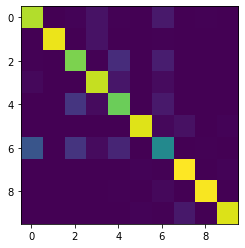

In [36]:
plt.imshow(matrix)